# Finding the best features to describe obesity with given dataset from UCL
The notebook is as follows:
- First understanding the data
- I did Explotary Data Analysis
- Feature Analysis and Feature Engineering
- Model (Random Forest, XGBoost and SVM)
- The random forest is created from scratch and compare my model with sklearn.
- Two important tools used for feature analysis.
  - LIME
  - SHAP
- And I also tried to use PCA but the accuracies decreased.

#Understanding Dataset


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict
from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from collections import Counter
from sklearn.tree import plot_tree
import shap
import io
from PIL import Image
import math
try:
  import lime
  from ucimlrepo import fetch_ucirepo
  from sklearn_evaluation import plot
except:
  !pip install lime
  !pip install ucimlrepo
  !pip install sklearn-evaluation
from lime.lime_tabular import LimeTabularExplainer
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b5a604dadc20bc46038991ef6c4b8de5d8805535df004f7fee2016205c4de088
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
# fetching data from uci directly
df_fetch = fetch_ucirepo(id=544)
X = df_fetch.data.features
y = df_fetch.data.targets
df = pd.concat([X, y], axis=1)

### Analyzing data

In [ ]:
df.head().T

0                      1  \
Gender                                         Female                 Female   
Age                                              21.0                   21.0   
Height                                           1.62                   1.52   
Weight                                           64.0                   56.0   
family_history_with_overweight                    yes                    yes   
FAVC                                               no                     no   
FCVC                                              2.0                    3.0   
NCP                                               3.0                    3.0   
CAEC                                        Sometimes              Sometimes   
SMOKE                                              no                    yes   
CH2O                                              2.0                    3.0   
SCC                                                no                    yes   
FAF                                               0.0                    3.0   
TUE                                               1.0                    0.0   
CALC                                               no              Sometimes   
MTRANS                          Public_Transportation  Public_Transportation   
NObeyesdad                              Normal_Weight          Normal_Weight   

                                                    2                   3  \
Gender                                           Male                Male   
Age                                              23.0                27.0   
Height                                            1.8                 1.8   
Weight                                           77.0                87.0   
family_history_with_overweight                    yes                  no   
FAVC                                               no                  no   
FCVC                                              2.0                 3.0   
NCP                                               3.0                 3.0   
CAEC                                        Sometimes           Sometimes   
SMOKE                                              no                  no   
CH2O                                              2.0                 2.0   
SCC                                                no                  no   
FAF                                               2.0                 2.0   
TUE                                               1.0                 0.0   
CALC                                       Frequently          Frequently   
MTRANS                          Public_Transportation             Walking   
NObeyesdad                              Normal_Weight  Overweight_Level_I   

                                                    4  
Gender                                           Male  
Age                                              22.0  
Height                                           1.78  
Weight                                           89.8  
family_history_with_overweight                     no  
FAVC                                               no  
FCVC                                              2.0  
NCP                                               1.0  
CAEC                                        Sometimes  
SMOKE                                              no  
CH2O                                              2.0  
SCC                                                no  
FAF                                               0.0  
TUE                                               0.0  
CALC                                        Sometimes  
MTRANS                          Public_Transportation  
NObeyesdad                        Overweight_Level_II

Attributes related with eating habits are:

- Frequent consumption of high caloric food (FAVC),

- Frequency of consumption of vegetables (FCVC),

- Number of main meals (NCP),

- Consumption of food between meals (CAEC),

- Consumption of water daily (CH20),

- and Consumption of alcohol (CALC).

Attributes related with the physical condition are:
Calories consumption monitoring (SCC),

- Physical activity frequency (FAF),

- Time using technology devices (TUE),

- Transportation used (MTRANS),

Other variables were:
- Gender, Age, Height and Weight.

Finally, all data was labeled and the class variable NObesity was created with the values of: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III, based on Equation (1) and information from WHO and Mexican Normativity.

In [ ]:
df['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [ ]:
print(f"Dataset's shape: {df.shape}")
print(f"Does dataset have missing values? \n{df.isnull().sum()}")

Dataset's shape: (2111, 17)
Does dataset have missing values? 
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [ ]:
print(f'Checking duplications: {df.duplicated().sum()}')
# there are 24 duplicate records
# df = df.drop_duplicates() #removing duplicates

Checking duplications: 24



By looking at the dataset what i can say is that I will perform clustering first and move to classification.

In [ ]:
df.info()
# The features are of different types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
df.describe()

Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75%       2.477420     1.666678     1.000000  
max       3.000000     3.000000     2.000000

## EDA

In [ ]:
sorted_labels = ['Insufficient_Weight', 'Normal_Weight',
 'Overweight_Level_I', 'Overweight_Level_II',
 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

target = df['NObeyesdad']

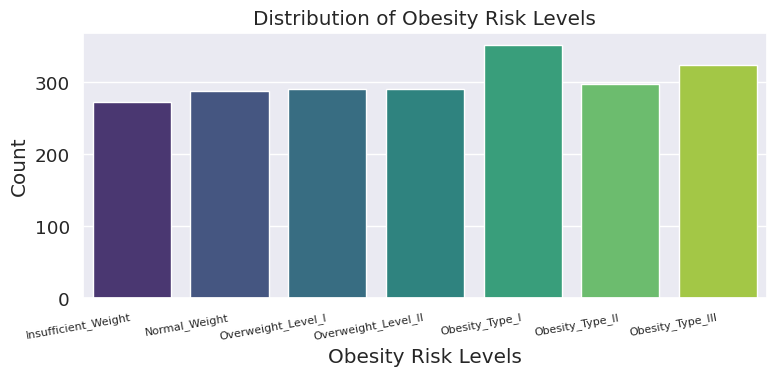

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=target, order=sorted_labels, palette='viridis')

plt.title('Distribution of Obesity Risk Levels')
plt.xlabel('Obesity Risk Levels')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
'''The data has one problem here
IN THE DATASET WE GOT THAT THE PEOPLE WHO HAVE OBESITY TYPE 2 ARE ALL MALES
AND ALL THE OBESITY 3 TYPE GENDER ARE FEMALE'''
obesity_type_II_df = df[df['NObeyesdad'] == 'Obesity_Type_II']
gender_counts = obesity_type_II_df['Gender'].value_counts()
gender_counts

Gender
Male      295
Female      2
Name: count, dtype: int64

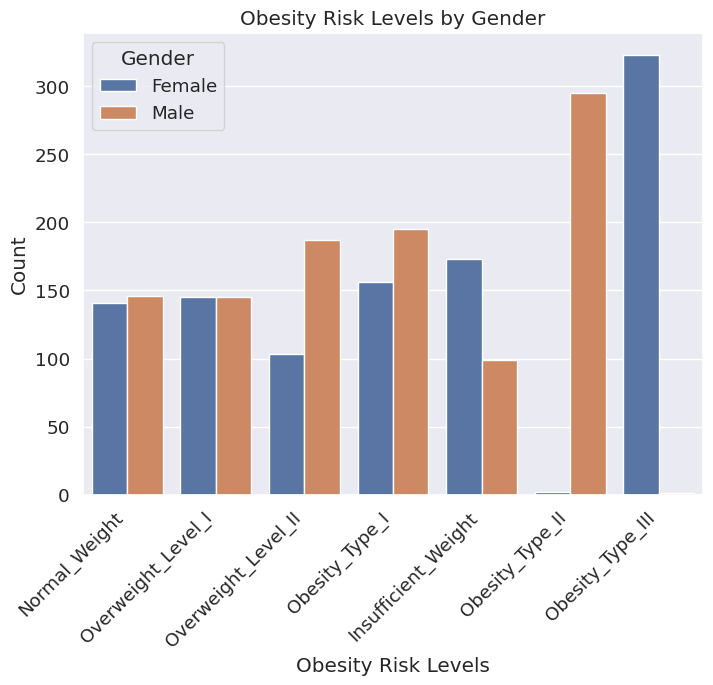

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='NObeyesdad', hue='Gender', data=df)
plt.title('Obesity Risk Levels by Gender')
plt.xlabel('Obesity Risk Levels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

We can two approaches with this dataset a classification and regression but before that i will convert the target values to numeric labels from string labels.

In [ ]:
# i encode the lables manually i can also do this with sklearn.preprocessing.LabelEncoder
custom_mapping = {'Insufficient_Weight': 0,
                  'Normal_Weight': 1,
                  'Overweight_Level_I': 2,
                  'Overweight_Level_II': 3,
                  'Obesity_Type_I': 4,
                  'Obesity_Type_II': 5,
                  'Obesity_Type_III': 6}
reversed_mapping = {v: k for k, v in custom_mapping.items()}

df['NObesity_encoded'] = df['NObeyesdad'].map(custom_mapping)
print(df[['NObeyesdad', 'NObesity_encoded']].head())

            NObeyesdad  NObesity_encoded
0        Normal_Weight                 1
1        Normal_Weight                 1
2        Normal_Weight                 1
3   Overweight_Level_I                 2
4  Overweight_Level_II                 3


I am going to split the dataset in 80% for training and 20% test.

Shuffling: We use np.random.permutation to generate a shuffled array of row indices. This helps ensure the split is random.

In [ ]:
''' There are two methods to do this using train_split from sklearn or slicing
I will use slicing since it's not a very big dataset'''

np.random.seed(8)
shuffled_indices = np.random.permutation(len(df))
train_size = int(0.8 * len(df))

train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

train_df = df.iloc[train_indices].reset_index(drop=True)
test_df = df.iloc[test_indices].reset_index(drop=True)

In [ ]:
X_train = train_df.drop(['NObeyesdad', 'NObesity_encoded'], axis=1)
y_train = train_df['NObesity_encoded']

X_test = test_df.drop(['NObeyesdad', 'NObesity_encoded'], axis=1)
y_test = test_df['NObesity_encoded']

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Training set shape: (1688, 16)
Test set shape: (423, 16)
Training target shape: (1688,)
Test target shape: (423,)


In [ ]:
categorical_features = X_train.columns[X_train.dtypes=="object"].tolist()
numeric_features = X_train.columns[X_train.dtypes!="object"].tolist()

The Features which has 2 unique values are binary like which yes or no answers.

We can encode them as well into 1 and 0.

The CAEC, CALC and MTRANS have more than two unique values that means we have to use onehot encoding.

In [ ]:
X_train[categorical_features].head()

Gender family_history_with_overweight FAVC       CAEC SMOKE SCC       CALC  \
0    Male                            yes  yes  Sometimes    no  no  Sometimes   
1    Male                             no  yes  Sometimes   yes  no  Sometimes   
2  Female                            yes   no  Sometimes    no  no         no   
3  Female                            yes  yes  Sometimes    no  no  Sometimes   
4    Male                            yes  yes  Sometimes    no  no  Sometimes   

                  MTRANS  
0  Public_Transportation  
1  Public_Transportation  
2  Public_Transportation  
3  Public_Transportation  
4  Public_Transportation

In [ ]:
X_train[numeric_features].head()

Age    Height      Weight      FCVC  NCP      CH2O       FAF  \
0  21.980847  1.819875  106.048516  2.000000  3.0  2.745242  0.000000   
1  26.000000  1.700000   70.000000  2.000000  3.0  1.000000  0.000000   
2  20.634694  1.568188   67.904023  2.512719  3.0  1.131169  0.095389   
3  26.000000  1.608283  105.359688  3.000000  3.0  2.476002  0.000000   
4  18.000000  1.767058   51.132809  2.708965  3.0  1.873004  1.217180   

        TUE  
0  0.808980  
1  0.000000  
2  1.000000  
3  0.546345  
4  1.000000

The weight feature has very large values compare to other features so we have to nomalize them.

My approach is to visualize every feature and closely look what is going on with the them.

### Plotting

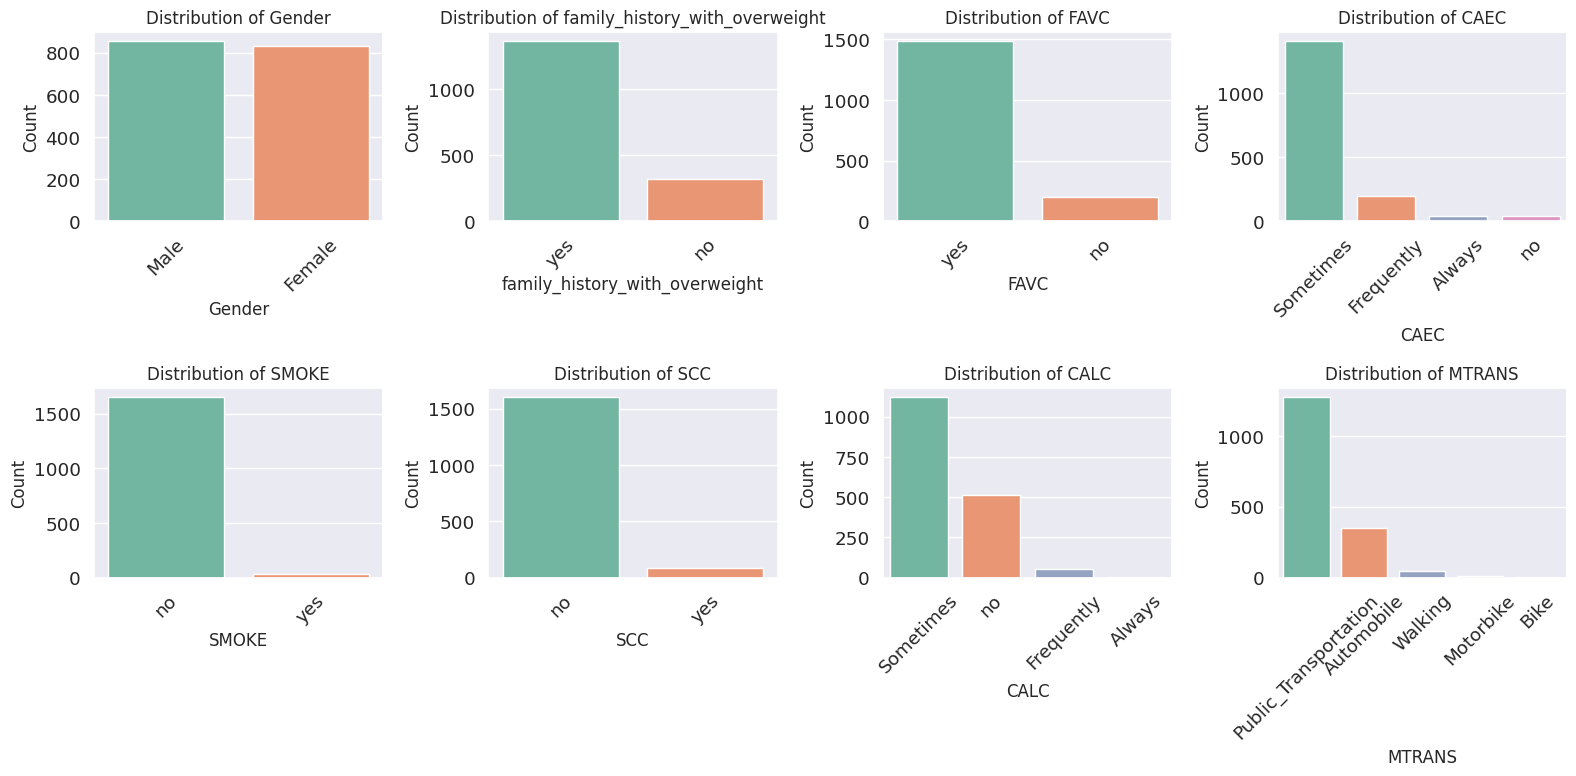

In [ ]:
n_features = len(categorical_features)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, feature in zip(axes, categorical_features):
    sns.countplot(x=feature, data=X_train, hue=feature,
                  order=X_train[feature].value_counts().index,
                  palette="Set2", ax=ax)
    ax.set_title(f"Distribution of {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.tick_params(axis='x', rotation=45)

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

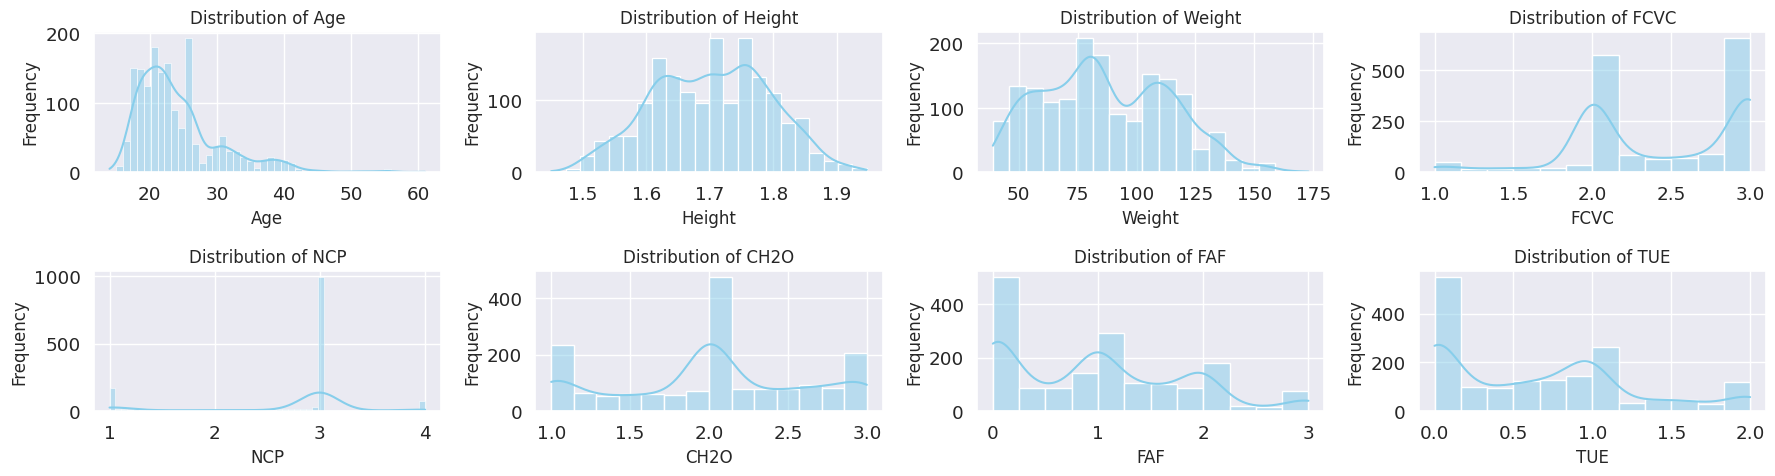

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 5))
axes = axes.flatten()
for ax, feature in zip(axes, numeric_features):
    sns.histplot(X_train[feature], kde=True, color='skyblue', ax=ax)
    ax.set_title(f"Distribution of {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Now proceed to process the categorical features by encoding them using the OneHotEncoder by Scikit-learn

# Feature Analysis and Engineer

In [ ]:
X_train.head()

Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  21.980847  1.819875  106.048516                            yes   
1    Male  26.000000  1.700000   70.000000                             no   
2  Female  20.634694  1.568188   67.904023                            yes   
3  Female  26.000000  1.608283  105.359688                            yes   
4    Male  18.000000  1.767058   51.132809                            yes   

  FAVC      FCVC  NCP       CAEC SMOKE      CH2O SCC       FAF       TUE  \
0  yes  2.000000  3.0  Sometimes    no  2.745242  no  0.000000  0.808980   
1  yes  2.000000  3.0  Sometimes   yes  1.000000  no  0.000000  0.000000   
2   no  2.512719  3.0  Sometimes    no  1.131169  no  0.095389  1.000000   
3  yes  3.000000  3.0  Sometimes    no  2.476002  no  0.000000  0.546345   
4  yes  2.708965  3.0  Sometimes    no  1.873004  no  1.217180  1.000000   

        CALC                 MTRANS  
0  Sometimes  Public_Transportation  
1  Sometimes  Public_Transportation  
2         no  Public_Transportation  
3  Sometimes  Public_Transportation  
4  Sometimes  Public_Transportation

In [ ]:
X_train['BMI'] = X_train['Weight'] / (X_train['Height'] ** 2)
X_test['BMI'] = X_test['Weight'] / (X_test['Height'] ** 2)

We then combine 'FAF' (Physical activity frequency) with 'TUE' (Time using technology devices) to create a feature representing the balance between physical activity and sedentary behavior.

In [ ]:
X_train['Physical_Activity_Level'] = X_train['FAF'] - X_train['TUE']
X_test['Physical_Activity_Level'] = X_test['FAF'] - X_test['TUE']

X_train['Meal_Habits'] = X_train['FCVC'] * X_train['NCP']
X_test['Meal_Habits'] = X_test['FCVC'] * X_test['NCP']

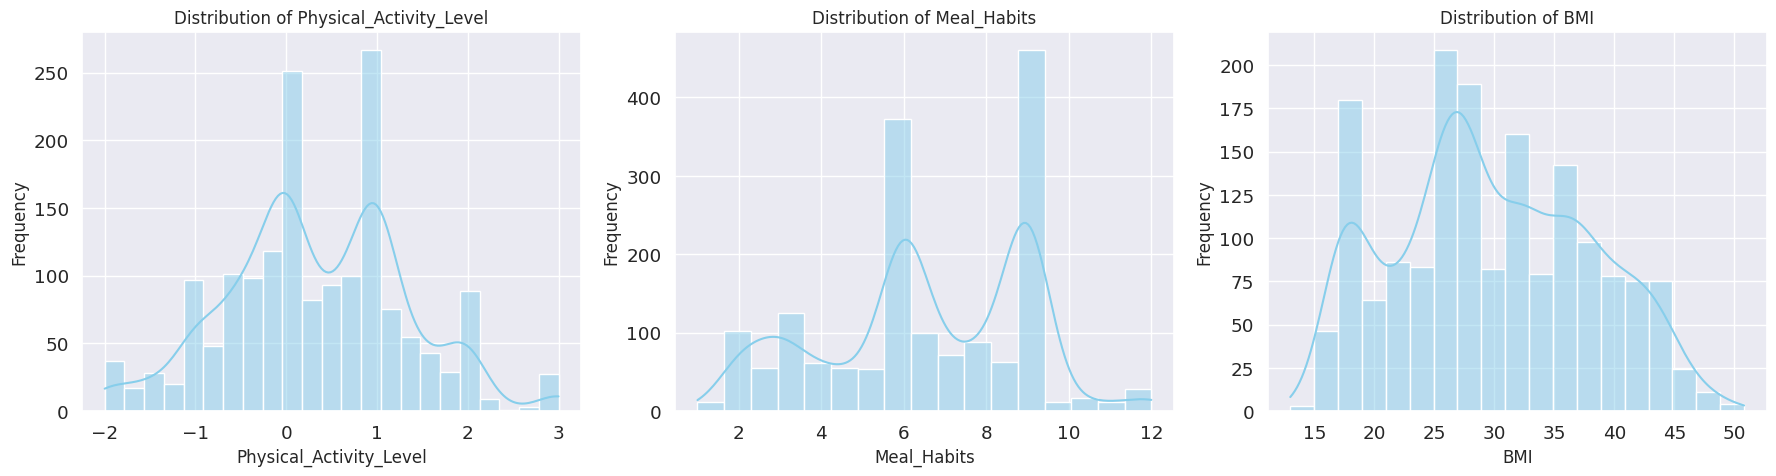

' The plots are normally distributed so i assumed everything is good here'

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(X_train['Physical_Activity_Level'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Distribution of Physical_Activity_Level", fontsize=12)
axes[0].set_xlabel("Physical_Activity_Level", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

sns.histplot(X_train['Meal_Habits'], kde=True, color='skyblue', ax=axes[1])
axes[1].set_title("Distribution of Meal_Habits", fontsize=12)
axes[1].set_xlabel("Meal_Habits", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

sns.histplot(X_train['BMI'], kde=True, color='skyblue', ax=axes[2])
axes[2].set_title("Distribution of BMI", fontsize=12)
axes[2].set_xlabel("BMI", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

''' The plots are normally distributed so i assumed everything is good here'''

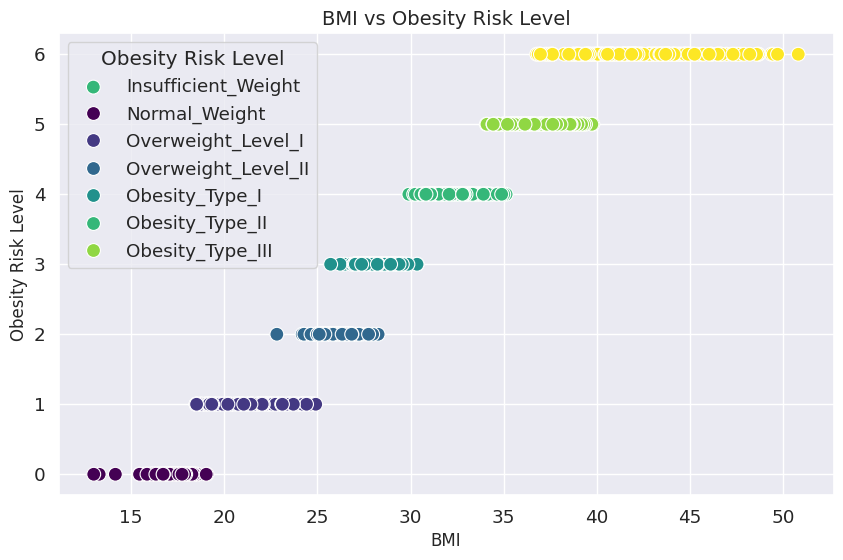

'There is clear indication that BMI is one of the most important factor when knowing there obesity level\nThe graph shows how linear is the relation of bmi and the obesity level'

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['BMI'], y=y_train, hue=y_train, palette='viridis', s=100)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Obesity Risk Level', fontsize=12) # More descriptive y-axis label
plt.title('BMI vs Obesity Risk Level', fontsize=14)
plt.legend(title='Obesity Risk Level', loc='upper left', labels=sorted_labels) # Custom legend labels
plt.show()

'''There is clear indication that BMI is one of the most important factor when knowing there obesity level
The graph shows how linear is the relation of bmi and the obesity level'''

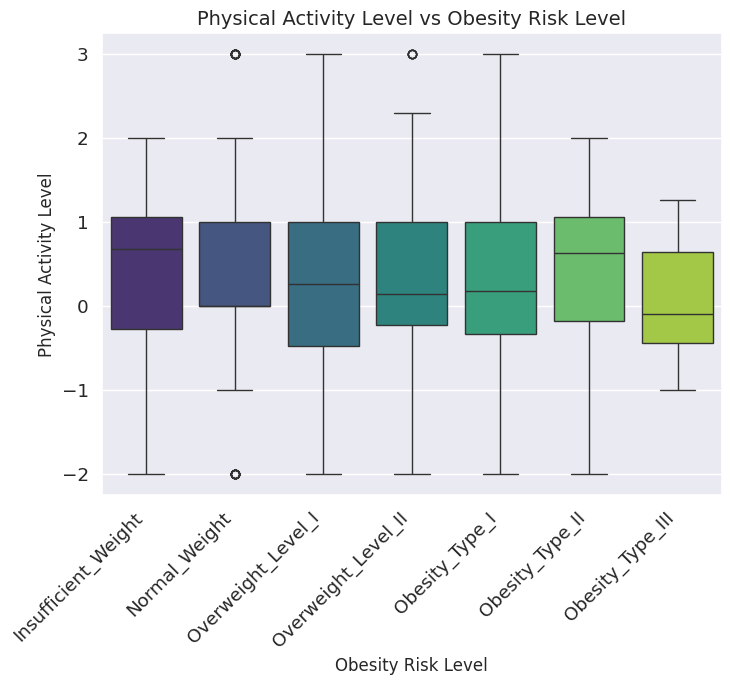

'If we compare the insufficient weight to obesity_type 3 we can see that the median of obesity type 3 is much lower than the others. There are 3 outliers i can see '

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['Physical_Activity_Level'], palette='viridis')
plt.xlabel('Obesity Risk Level', fontsize=12)
plt.ylabel('Physical Activity Level', fontsize=12)
plt.title('Physical Activity Level vs Obesity Risk Level', fontsize=14)
plt.xticks(ticks=range(len(sorted_labels)), labels=sorted_labels, rotation=45, ha='right')
plt.show()

'''If we compare the insufficient weight to obesity_type 3 we can see that the median of obesity type 3 is much lower than the others. There are 3 outliers i can see '''

In [ ]:
''' I had to double check because the new feature created can easily distinguese obesity type 3 because the values in the new features were 9
Check the graph of Meal_Habits vs Obesity Risk Level
I think this feature is not much useful but i still used it'''
X_train[y_train == 6]['Meal_Habits']

3       9.0
8       9.0
15      9.0
40      9.0
42      9.0
       ... 
1656    9.0
1664    9.0
1679    9.0
1683    9.0
1687    9.0
Name: Meal_Habits, Length: 271, dtype: float64

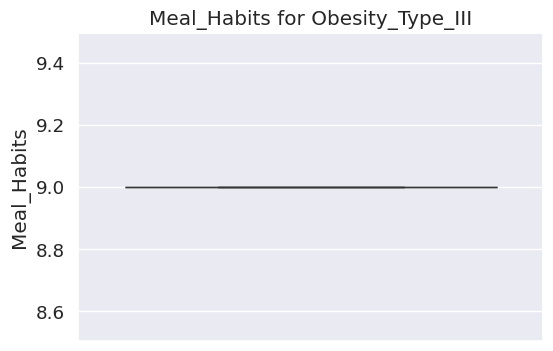

In [ ]:
obesity_type_III_data = X_train[y_train == 6]['Meal_Habits']
plt.figure(figsize=(6, 4))
sns.boxplot(y=obesity_type_III_data, palette='viridis')
plt.title('Meal_Habits for Obesity_Type_III')
plt.ylabel('Meal_Habits')
plt.show()

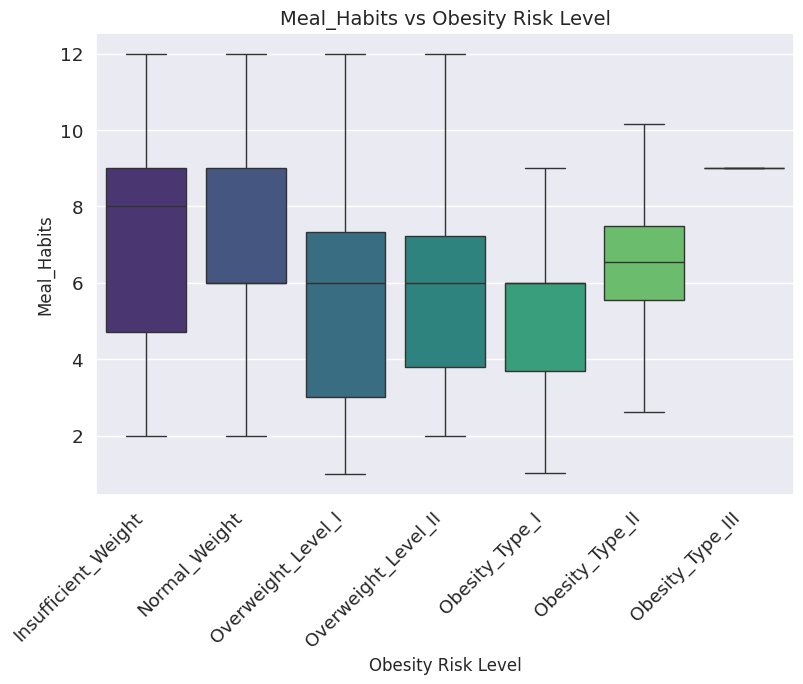

In [ ]:
plt.figure(figsize=(9, 6))
sns.boxplot(x=y_train, y=X_train['Meal_Habits'], palette='viridis', whis=1.5, showfliers=False)
plt.xlabel('Obesity Risk Level', fontsize=12)
plt.ylabel('Meal_Habits', fontsize=12)
plt.title('Meal_Habits vs Obesity Risk Level', fontsize=14)
plt.xticks(ticks=range(len(sorted_labels)), labels=sorted_labels, rotation=45, ha='right')
plt.show()

In [ ]:
categorical_features = X_train.columns[X_train.dtypes=="object"].tolist()
numeric_features = X_train.columns[X_train.dtypes!="object"].tolist()

In [ ]:
# Standardize numeric features
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_numeric_scaled  = scaler.transform(X_test[numeric_features])

# Convert back to DataFrame (keeping original index)
X_train_numeric = pd.DataFrame(X_train_numeric_scaled, columns=numeric_features, index=X_train.index)
X_test_numeric  = pd.DataFrame(X_test_numeric_scaled, columns=numeric_features, index=X_test.index)

In [ ]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit encoder on combined categorical data to ensure consistency
encoder.fit(pd.concat([X_train[categorical_features], X_test[categorical_features]], axis=0))
train_encoded = encoder.transform(X_train[categorical_features])
test_encoded  = encoder.transform(X_test[categorical_features])

# Create DataFrames for the encoded features (with the same index)
encoded_columns = encoder.get_feature_names_out(categorical_features)
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_columns, index=X_train.index)
test_encoded_df  = pd.DataFrame(test_encoded, columns=encoded_columns, index=X_test.index)

In [ ]:
# I reviewed the data closely and i was finding which features can be combined.
combine_columns = ['CALC_Always', 'CALC_Frequently']

train_encoded_df['CALC_Always|Frequently'] = train_encoded_df[combine_columns].sum(axis=1)
test_encoded_df['CALC_Always|Frequently'] = test_encoded_df[combine_columns].sum(axis=1)

train_encoded_df = train_encoded_df.drop(columns=combine_columns).set_index(X_train.index)
test_encoded_df = test_encoded_df.drop(columns=combine_columns).set_index(X_test.index)

In [ ]:
# Build final training and test sets by concatenating numeric and encoded categorical features
final_train_scaled = pd.concat([X_train_numeric, train_encoded_df], axis=1)
final_test_scaled  = pd.concat([X_test_numeric, test_encoded_df], axis=1)
final_train_scaled = final_train_scaled.reindex(sorted(final_train_scaled.columns), axis=1)
final_test_scaled  = final_test_scaled.reindex(sorted(final_test_scaled.columns), axis=1)

In [ ]:
final_train_scaled.columns

Index(['Age', 'BMI', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes',
       'CAEC_no', 'CALC_Always|Frequently', 'CALC_Sometimes', 'CALC_no',
       'CH2O', 'FAF', 'FAVC_no', 'FAVC_yes', 'FCVC', 'Gender_Female',
       'Gender_Male', 'Height', 'MTRANS_Automobile', 'MTRANS_Bike',
       'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking',
       'Meal_Habits', 'NCP', 'Physical_Activity_Level', 'SCC_no', 'SCC_yes',
       'SMOKE_no', 'SMOKE_yes', 'TUE', 'Weight',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes'],
      dtype='object')

In [ ]:
print("Final train shape:", final_train_scaled.shape)
print("Final test shape:", final_test_scaled.shape)

Final train shape: (1688, 33)
Final test shape: (423, 33)


In [ ]:
final_train_scaled

Age       BMI  CAEC_Always  CAEC_Frequently  CAEC_Sometimes  \
0    -0.354800  0.274110          0.0              0.0             1.0   
1     0.291453 -0.683261          0.0              0.0             1.0   
2    -0.571253 -0.267018          0.0              0.0             1.0   
3     0.291453  1.343775          0.0              0.0             1.0   
4    -0.994894 -1.646435          0.0              0.0             1.0   
...        ...       ...          ...              ...             ...   
1683 -0.467132  1.707644          0.0              0.0             1.0   
1684  0.028093 -0.105011          0.0              0.0             1.0   
1685  1.417006 -0.575115          0.0              0.0             1.0   
1686  0.217393  0.780398          0.0              0.0             1.0   
1687  0.210890  0.882279          0.0              0.0             1.0   

      CAEC_no  CALC_Always|Frequently  CALC_Sometimes  CALC_no      CH2O  ...  \
0         0.0                     0.0             1.0      0.0  1.182778  ...   
1         0.0                     0.0             1.0      0.0 -1.658684  ...   
2         0.0                     0.0             0.0      1.0 -1.445126  ...   
3         0.0                     0.0             1.0      0.0  0.744423  ...   
4         0.0                     0.0             1.0      0.0 -0.237330  ...   
...       ...                     ...             ...      ...       ...  ...   
1683      0.0                     0.0             1.0      0.0  0.373174  ...   
1684      0.0                     0.0             1.0      0.0  0.106098  ...   
1685      0.0                     0.0             1.0      0.0 -1.658684  ...   
1686      0.0                     0.0             1.0      0.0  0.199441  ...   
1687      0.0                     0.0             1.0      0.0 -1.265692  ...   

           NCP  Physical_Activity_Level  SCC_no  SCC_yes  SMOKE_no  SMOKE_yes  \
0     0.406843                -1.145348     1.0      0.0       1.0        0.0   
1     0.406843                -0.334328     1.0      0.0       0.0        1.0   
2     0.406843                -1.241220     1.0      0.0       1.0        0.0   
3     0.406843                -0.882050     1.0      0.0       1.0        0.0   
4     0.406843                -0.116600     1.0      0.0       1.0        0.0   
...        ...                      ...     ...      ...       ...        ...   
1683  0.406843                 0.428292     1.0      0.0       1.0        0.0   
1684 -0.006544                -0.696862     1.0      0.0       1.0        0.0   
1685  0.406843                -2.339370     1.0      0.0       1.0        0.0   
1686  0.406843                 0.789536     1.0      0.0       1.0        0.0   
1687  0.406843                -0.928758     1.0      0.0       1.0        0.0   

           TUE    Weight  family_history_with_overweight_no  \
0     0.241968  0.715745                                0.0   
1    -1.093847 -0.635976                                1.0   
2     0.557386 -0.714569                                0.0   
3    -0.191704  0.689916                                0.0   
4     0.557386 -1.343444                                0.0   
...        ...       ...                                ...   
1683  0.308440  1.751197                                0.0   
1684  0.547126 -0.063717                                0.0   
1685  2.208620 -0.410992                                1.0   
1686 -1.093847  1.067460                                0.0   
1687  0.313602  0.670684                                0.0   

      family_history_with_overweight_yes  
0                                    1.0  
1                                    0.0  
2                                    1.0  
3                                    1.0  
4                                    1.0  
...                                  ...  
1683                                 1.0  
1684                                 1.0  
1685                            

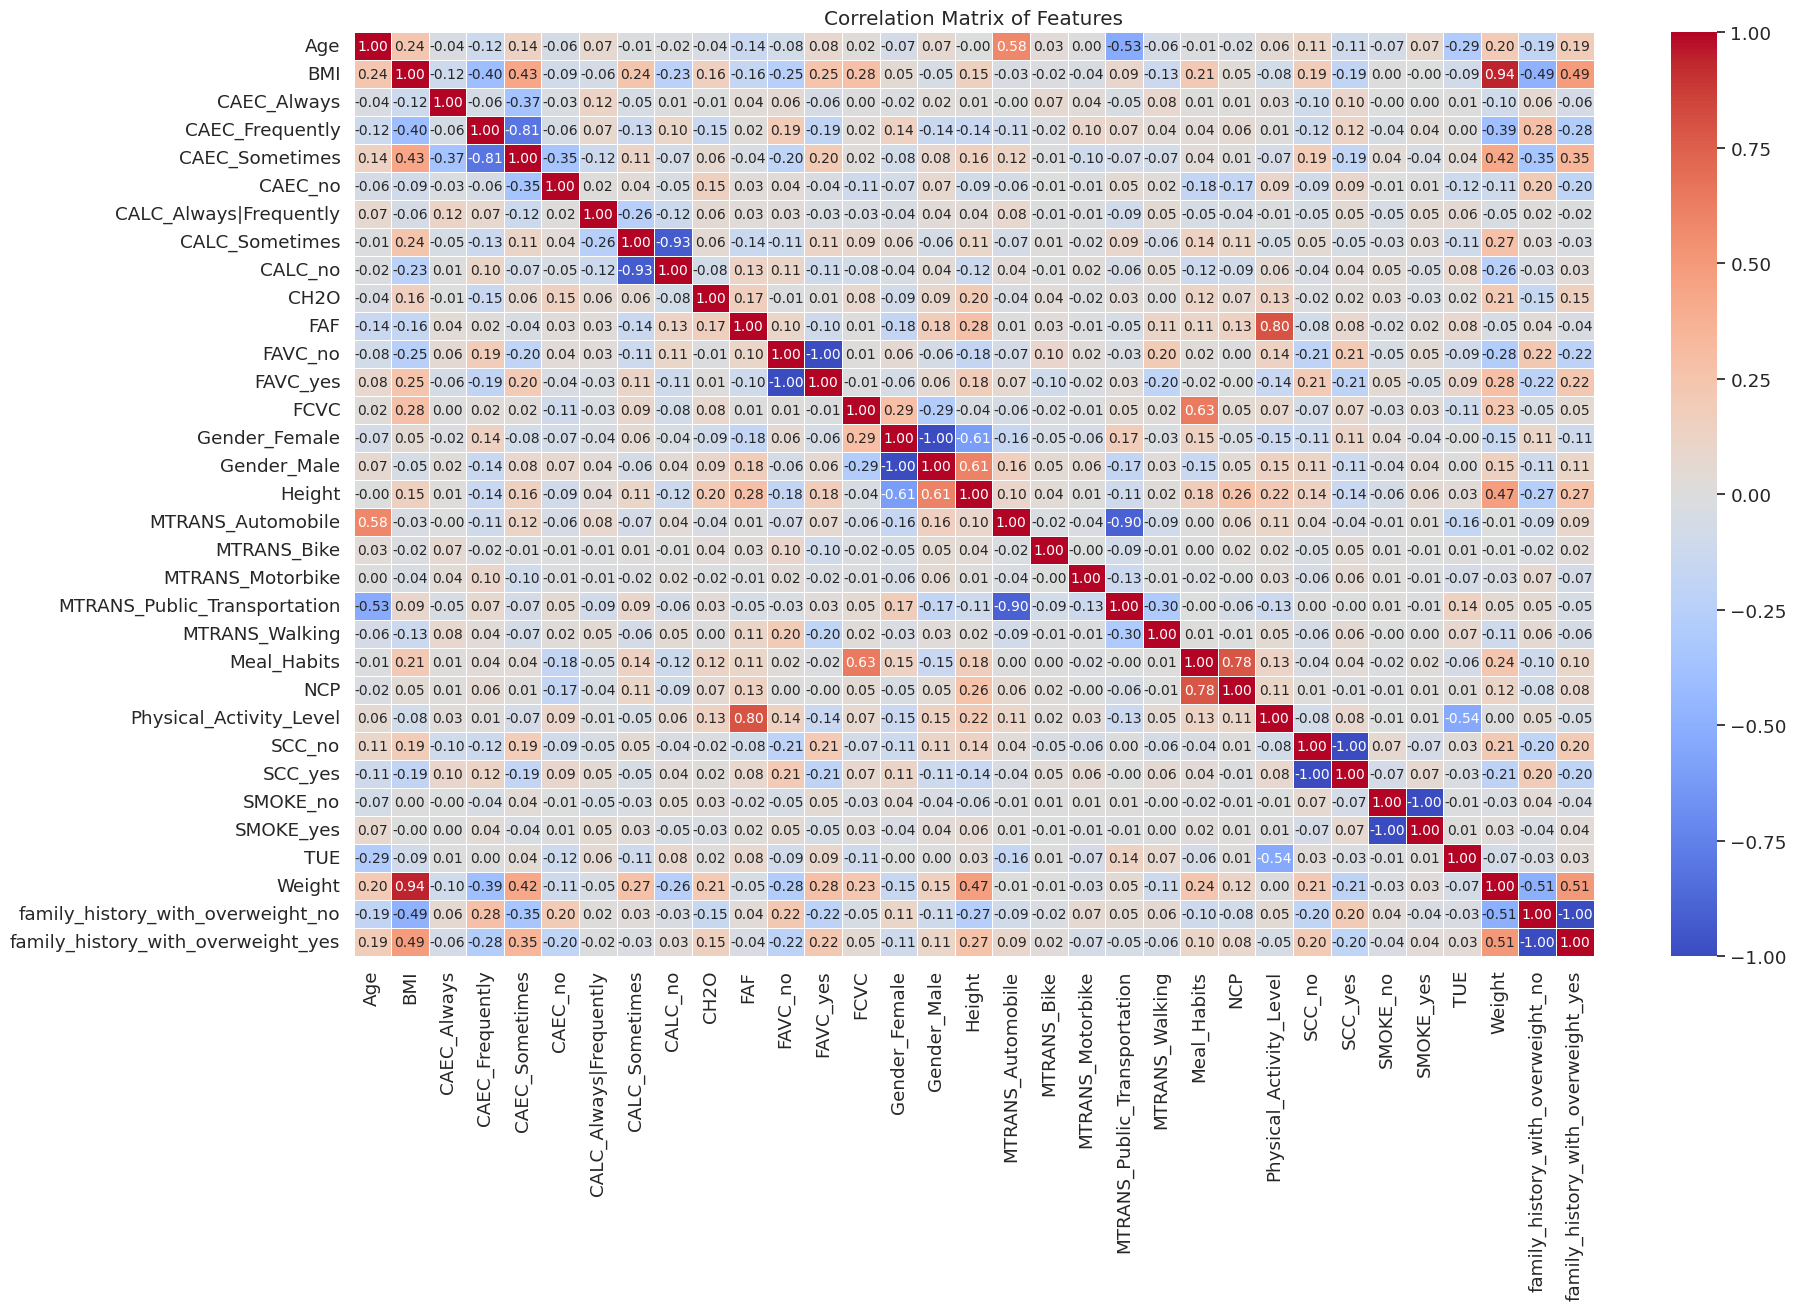

In [ ]:
correlation_matrix = final_train_scaled.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"fontsize": 10})
plt.title('Correlation Matrix of Features')
plt.show()

There are few features which were corriletting a lot like **weight with bmi** because it was created by it and the **weight and height** are little related. the interesting one is **MTRANS_Automobile and Age** and family history with weight.

## Adversarial validation

Adversarial validation
We take the code for adversarial validation from the Kaggle Book: https://github.com/PacktPublishing/The-Kaggle-Book/blob/main/chapter_06/adversarial-validation-example.ipynb

Adversarial validation is a technique used to assess the degree of similarity between the training and test datasets. It works by training a model to distinguish between the two datasets. If the model can effectively differentiate between them, it suggests that there are significant differences in the distributions of the features, which could lead to poor generalization performance.

In [ ]:
X =  pd.concat([final_train_scaled, final_test_scaled], axis=0)
y = [0] * len(final_train_scaled) + [1] * len(final_test_scaled)

model = RandomForestClassifier(random_state=8)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.495


# Modelling

In [ ]:
accuracies = {}

### XGBoost

In [ ]:
print(final_train_scaled.shape)
print(y_train.shape)

(1688, 33)
(1688,)


In [ ]:
xgb_clf = XGBClassifier(booster='gbtree',
                    tree_method="hist",
                    objective='multi:softmax',
                    num_class=len(set(y_train)),
                    n_estimators=300,
                    max_depth=6,
                    verbosity=0)

xgb_clf.fit(final_train_scaled, y_train)
y_pred = xgb_clf.predict(final_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
accuracies['XGBoost with CrossValidation'] = accuracy
print(f'Cross-validated Accuracy: {accuracy:.3f}')
accuracies['XGBoost'] = accuracy

Cross-validated Accuracy: 0.979


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Grid search is used to find the best hyperparameters from param_grid dict. it will also apply cross validation folds
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=len(set(y_train))),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2)
grid_search_xgb.fit(final_train_scaled, y_train)
print("Best parameters:", grid_search_xgb.best_params_)
print("Best score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best score: 0.9822309623724828


Accuracy on test data: 0.986


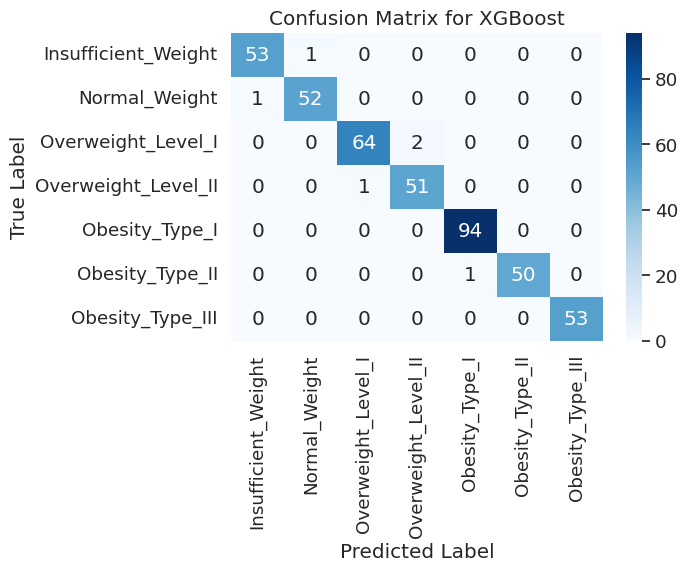

' The size of test data is 423. the accuracy is very good we only got few\nwrong like the normal weight got classified as insufficient and overweight with overweight 2.\n'

In [ ]:
best_xgb_model = grid_search_xgb.best_estimator_
y_pred = best_xgb_model.predict(final_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.3f}")
accuracies['XGBoost with GridSearch on test data'] = accuracy

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()

''' The size of test data is 423. the accuracy is very good we only got few
wrong like the normal weight got classified as insufficient and overweight with overweight 2.
'''

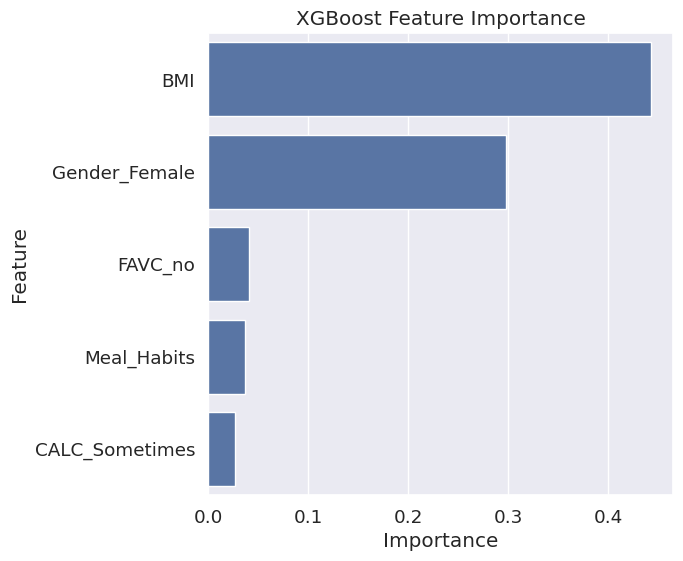

In [ ]:
feature_importances = best_xgb_model.feature_importances_
# xg_boost has inbuild method to get best features selected or the important feature while training
importance_df_xgb = pd.DataFrame({
    'Feature': final_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb[:5], orient='h')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### XGboost Lime

In [ ]:
accuracy = best_xgb_model.score(final_test_scaled, y_test)
print("XGBoost Accuracy:", accuracy)
accuracies['XGBoost'] = accuracy

XGBoost Accuracy: 0.9858156028368794


In [ ]:
explainer_lime = LimeTabularExplainer(
    training_data=np.array(final_train_scaled),
    feature_names=final_train_scaled.columns,
    class_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'],
    mode='classification'
)


instance_to_show = 90
instance = final_test_scaled.iloc[instance_to_show]

exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=xgb_clf.predict_proba,
    num_features=8,
    top_labels=1
)
exp.show_in_notebook(show_table=True, show_all=False)
print(f'Real value: {reversed_mapping[y_test.iloc[instance_to_show]]}')

Real value: Obesity_Type_I


### SVM

In [ ]:
svm_clf = SVC(kernel='rbf', C=5)
svm_clf.fit(final_train_scaled, y_train)
y_pred = svm_clf.predict(final_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')
accuracies['SVM on test'] = accuracy

Accuracy: 0.962


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 15, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
}

# Used same methods as XGboost just changed with hyperparameters of SVM
grid_search_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_svc.fit(final_train_scaled, y_train)
print("Best parameters:", grid_search_svc.best_params_)
print("Best score:", grid_search_svc.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 15, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.9609098730532193


In [ ]:
# subset = {'kernel': 'rbf', 'C': grid_search_svc.best_params_['C']}
# # Use best C value for clearer comparison across gammas
# plot.grid_search(grid_search_svc.cv_results_, change='gamma', subset=subset)
# plt.title(f'Grid Search Results svm rbf')
# plt.ylabel('Accuracy')
# plt.xlabel('Gamma')
# plt.show()

In [ ]:
accuracies['SVM with GridSearch'] = grid_search_svc.best_score_

Accuracy on test data: 0.969


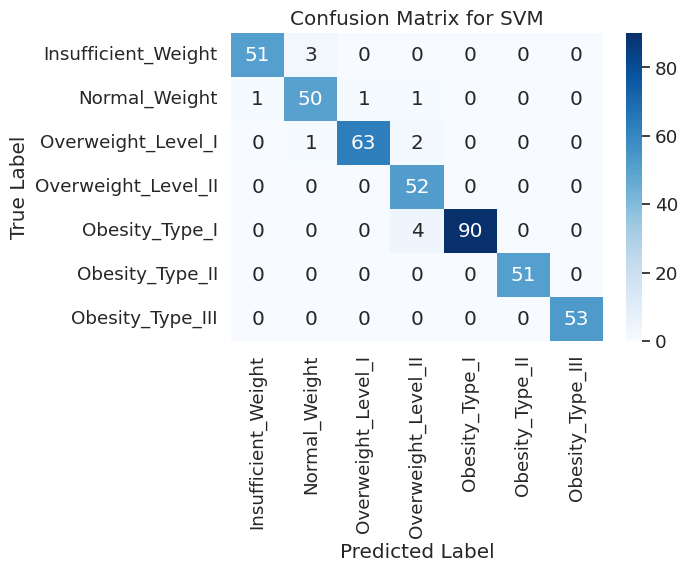

In [ ]:
best_svm_clf = SVC(**grid_search_svc.best_params_)
best_svm_clf.fit(final_train_scaled, y_train)

y_pred = best_svm_clf.predict(final_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.3f}")
accuracies['SVM with GridSearch on test data'] = accuracy

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

### Random Forest

#### Custom Model

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        if self.max_features is None:
            self.max_features = int(np.sqrt(self.n_features_))
        self.tree = self._build_tree(X, y, depth=0)

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / m
        return 1 - np.sum(probabilities ** 2)

    def _best_split(self, X, y):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None, None, None, None

        best_gini = self._gini(y)
        best_feature, best_threshold = None, None
        best_left_idx, best_right_idx = None, None

        features_idx = np.random.choice(n, self.max_features, replace=False)

        for feature in features_idx:
            values = np.unique(X[:, feature])
            for threshold in values:
                left_idx = np.where(X[:, feature] < threshold)[0]
                right_idx = np.where(X[:, feature] >= threshold)[0]

                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue

                gini_left = self._gini(y[left_idx])
                gini_right = self._gini(y[right_idx])
                weighted_gini = (len(left_idx) / m) * gini_left + (len(right_idx) / m) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
                    best_left_idx = left_idx
                    best_right_idx = right_idx

        return best_feature, best_threshold, best_left_idx, best_right_idx, best_gini

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if depth >= self.max_depth or num_samples < self.min_samples_split or self._gini(y) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"leaf": True, "value": leaf_value}

        best_feature, best_threshold, left_idx, right_idx, _ = self._best_split(X, y)
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {"leaf": True, "value": leaf_value}
        left_subtree = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)

        return {
            "leaf": False,
            "feature": best_feature,
            "threshold": best_threshold,
            "left": left_subtree,
            "right": right_subtree
        }

    def _predict_one(self, x, tree):
        if tree["leaf"]:
            return tree["value"]
        if x[tree["feature"]] < tree["threshold"]:
            return self._predict_one(x, tree["left"])
        else:
            return self._predict_one(x, tree["right"])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

# Random Forest Implementation

class RandomForest:
    def __init__(self, n_estimators=10, max_depth=10, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.trees = []
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for i in range(self.n_estimators):
            # Create a bootstrap sample
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            # Initialize and train a decision tree
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                max_features=self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Get predictions from each tree
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote for each sample
        predictions = []
        for i in range(X.shape[0]):
            vote_counts = Counter(tree_preds[:, i])
            predictions.append(vote_counts.most_common(1)[0][0])
        return np.array(predictions)

In [ ]:
# If your data is in pandas DataFrames, convert them to NumPy arrays:
X_train_np = final_train_scaled.values if hasattr(final_train_scaled, "values") else np.array(final_train_scaled)
X_test_np = final_test_scaled.values if hasattr(final_test_scaled, "values") else np.array(final_test_scaled)
y_train_np = y_train.values if hasattr(y_train, "values") else np.array(y_train)
y_test_np = y_test.values if hasattr(y_test, "values") else np.array(y_test)

In [ ]:
n_features = X_train_np.shape[1]
max_features = int(np.sqrt(n_features))

In [ ]:
rf = RandomForest(n_estimators=50, max_depth=20, min_samples_split=2, max_features=max_features)
rf.fit(X_train_np, y_train_np)

In [ ]:
y_pred_rf = rf.predict(X_test_np)
acc_rf = accuracy_score(y_test_np, y_pred_rf)
accuracies['Custom Random Forest'] = acc_rf
print("Random Forest from scratch Accuracy:", acc_rf)
print("Classification Report:\n", classification_report(y_test_np, y_pred_rf, target_names=sorted_labels))

Random Forest from scratch Accuracy: 0.9716312056737588
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.96      1.00      0.98        54
      Normal_Weight       0.93      0.94      0.93        53
 Overweight_Level_I       0.98      0.92      0.95        66
Overweight_Level_II       0.93      1.00      0.96        52
     Obesity_Type_I       0.99      0.97      0.98        94
    Obesity_Type_II       1.00      0.98      0.99        51
   Obesity_Type_III       1.00      1.00      1.00        53

           accuracy                           0.97       423
          macro avg       0.97      0.97      0.97       423
       weighted avg       0.97      0.97      0.97       423



### Random Forest from Sklearn

In [ ]:
model = RandomForestClassifier(random_state=0)
model.fit(final_train_scaled, y_train)

y_pred_rf = model.predict(final_test_scaled)
acc_rf_ran = accuracy_score(y_test, y_pred_rf)
accuracies['Random Forest on test set'] = acc_rf_ran
print("Random Forest:", acc_rf_ran)
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=sorted_labels))

Random Forest: 0.983451536643026
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.98      0.98      0.98        54
      Normal_Weight       0.93      0.96      0.94        53
 Overweight_Level_I       0.98      0.95      0.97        66
Overweight_Level_II       0.98      1.00      0.99        52
     Obesity_Type_I       1.00      0.99      0.99        94
    Obesity_Type_II       1.00      1.00      1.00        51
   Obesity_Type_III       1.00      1.00      1.00        53

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      0.98      0.98       423



In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search_rf.fit(final_train_scaled, y_train)
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(final_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy on test data: {accuracy_rf:.3f}")
accuracies['Random Forest with GridSearch on test data'] = accuracy_rf

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9828191666812985
Accuracy on test data: 0.981


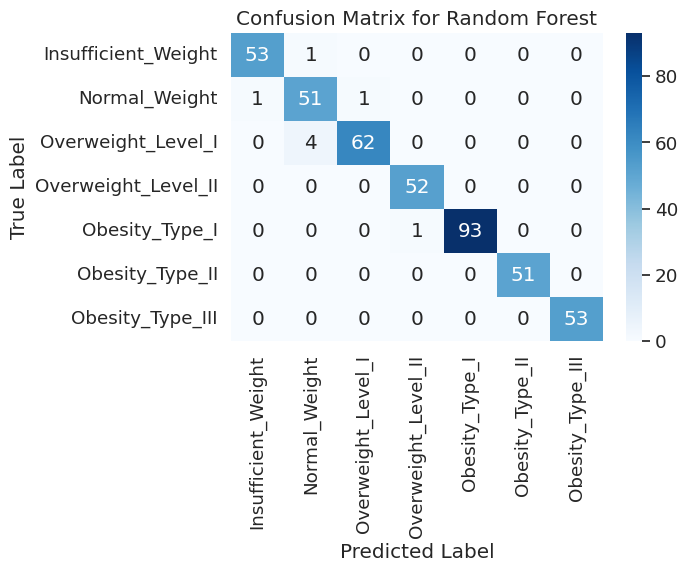

' The size of test data is 423. the accuracy is very good we only got few wrong like the normal weight got classified as insufficient and overweight with overweight 2.'

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

''' The size of test data is 423. the accuracy is very good we only got few wrong like the normal weight got classified as insufficient and overweight with overweight 2.'''

#### Random Forest Lime

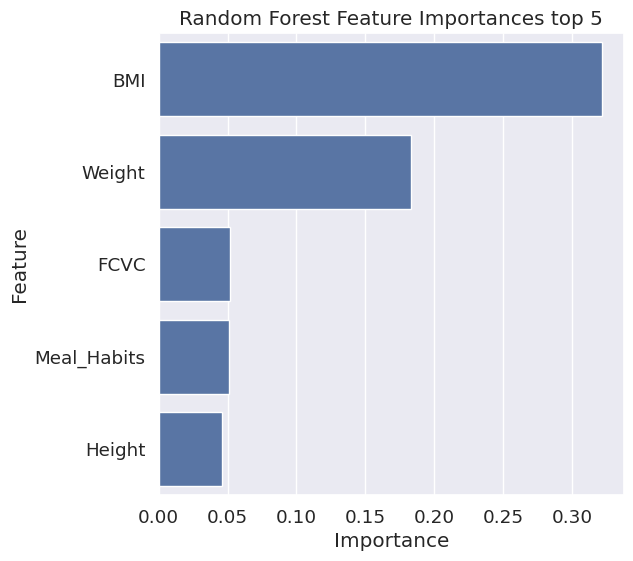

In [ ]:
overall_importances = model.feature_importances_
# the random forest also has important features as XGBoost
importance_df_rf = pd.DataFrame({
    'Feature': final_train_scaled.columns,
    'Importance': overall_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf[:5])
plt.title('Random Forest Feature Importances top 5')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
explainer_lime = LimeTabularExplainer(
    training_data=np.array(final_train_scaled),
    feature_names=final_train_scaled.columns,
    class_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
                 'Obesity_Type_III'],
    mode='classification'
)
instance_to_show = 90
instance = final_test_scaled.iloc[instance_to_show]



exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=8,
    top_labels=1
)

exp.show_in_notebook(show_table=True, show_all=False)
print(f'Real value: {reversed_mapping[y_test.iloc[instance_to_show]]}')

Real value: Obesity_Type_I


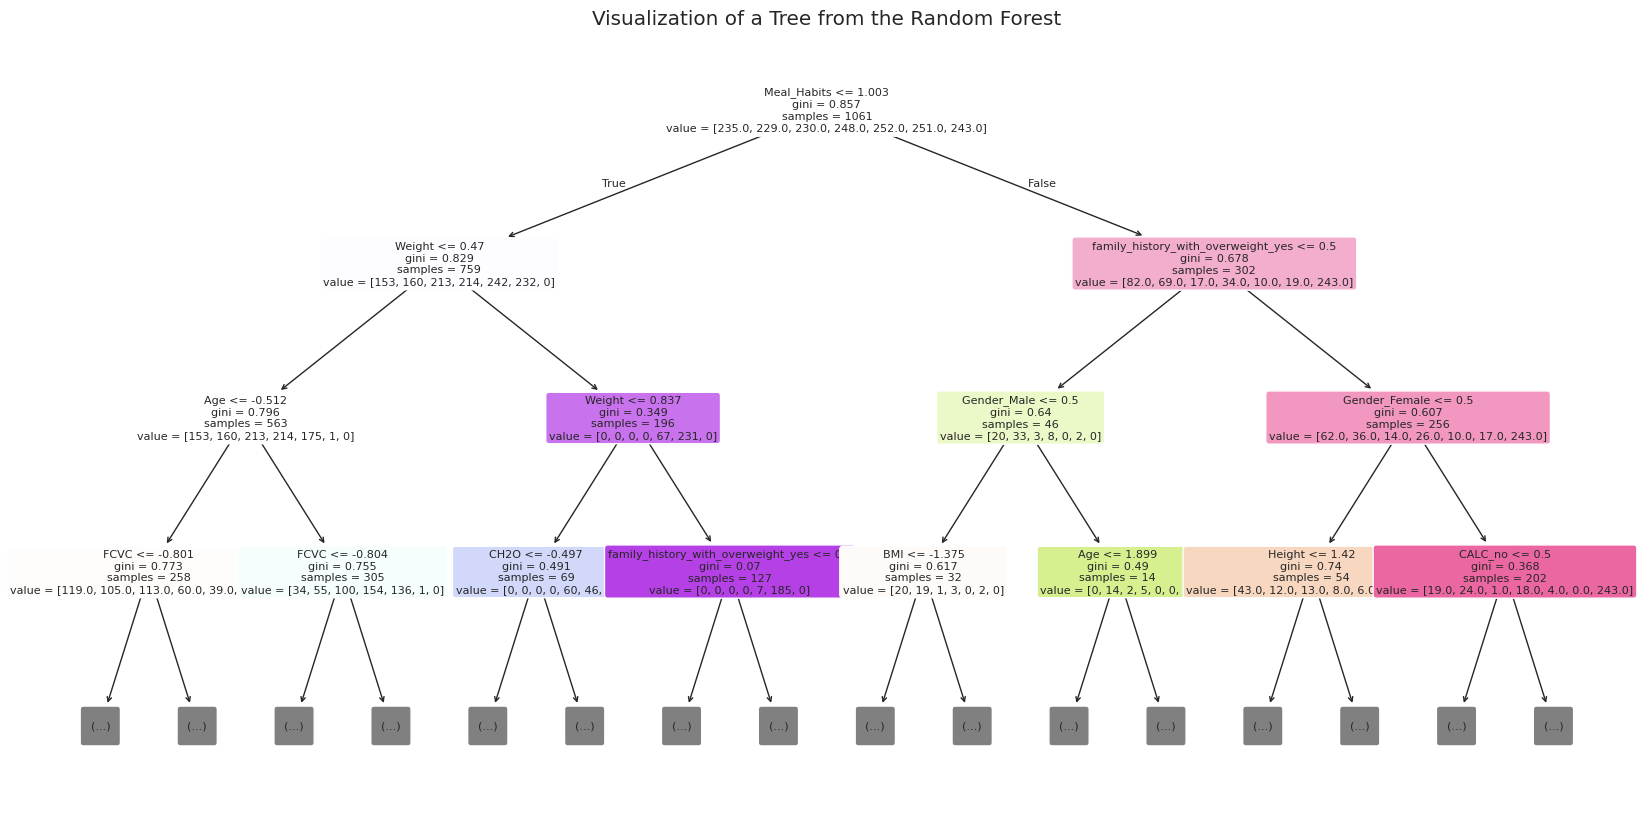

In [ ]:
estimator = model.estimators_[0]
# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=final_train_scaled.columns, filled=True, rounded=True, max_depth=3,fontsize=8)
# using max_depth to only see three depth
plt.title("Visualization of a Tree from the Random Forest")
plt.show()

### SHAP

In [ ]:
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap(final_test_scaled)  # shape: (423, 31, 7)

In [ ]:
# used gemini for this because i was getting errors
violin_images = []
dpi_val = 180
# Generate a violin plot for each class, capture it as an image, and store it.
for i, label in enumerate(sorted_labels):
    fig = plt.figure(figsize=(16, 12))
    shap.plots.violin(shap_values[:, :, i], final_test_scaled, plot_type="violin", show=False)
    # Save the figure to a buffer with higher DPI
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=dpi_val)
    buf.seek(0)
    img = Image.open(buf)
    violin_images.append(img)
    plt.close(fig)

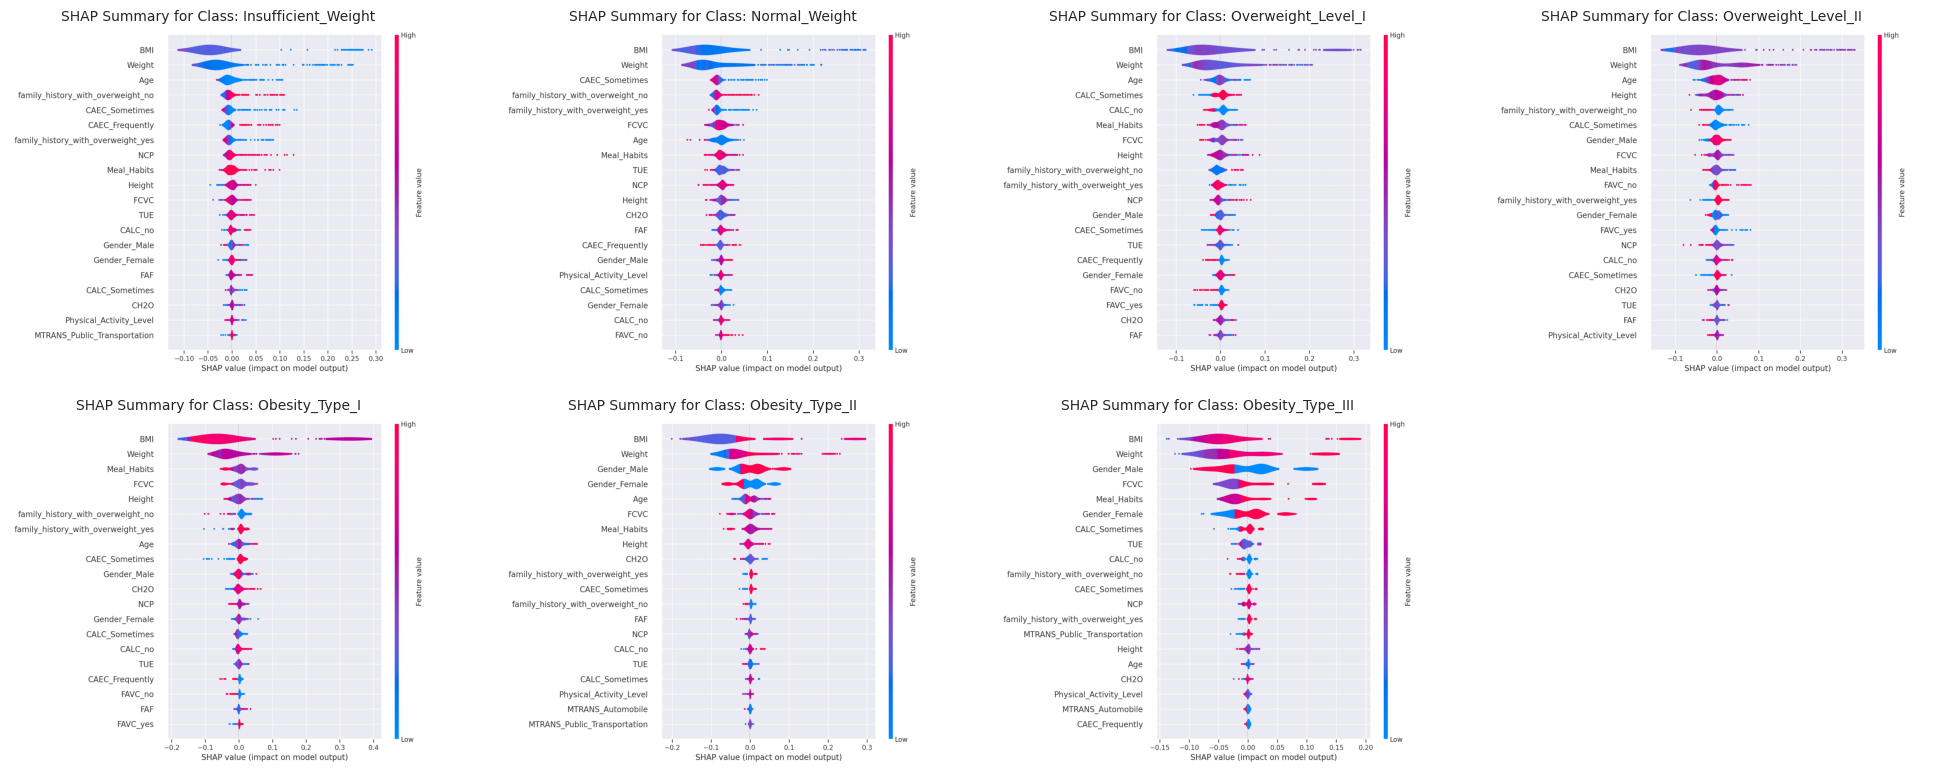

In [ ]:
n_labels = len(sorted_labels)
n_cols = 4
n_rows = math.ceil(n_labels / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()
for ax, img, label in zip(axes, violin_images, sorted_labels):
    ax.imshow(img)
    ax.set_title(f"SHAP Summary for Class: {label}", fontsize=10)
    ax.axis('off')

for j in range(len(violin_images), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
shap_array = shap_values.values  # shape: (423, 33, 7)
feature_names = np.array(final_test_scaled.columns)

# Dictionary to store top 10 features per class
top_features_by_class = {}

for class_idx, class_name in enumerate(sorted_labels):
    mean_abs_shap = np.mean(np.abs(shap_array[:, :, class_idx]), axis=0)
    top_indices = np.argsort(mean_abs_shap)[::-1][:10]
    top_features = feature_names[top_indices]
    top_features_by_class[class_name] = top_features.tolist()
top_features_df = pd.DataFrame(top_features_by_class)
top_features_df.index = [f"Rank {i+1}" for i in range(top_features_df.shape[0])]

In [ ]:
top_features_df

Insufficient_Weight  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                                  Age   
Rank 4    family_history_with_overweight_no   
Rank 5                       CAEC_Sometimes   
Rank 6                      CAEC_Frequently   
Rank 7   family_history_with_overweight_yes   
Rank 8                                  NCP   
Rank 9                          Meal_Habits   
Rank 10                              Height   

                              Normal_Weight  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                       CAEC_Sometimes   
Rank 4    family_history_with_overweight_no   
Rank 5   family_history_with_overweight_yes   
Rank 6                                 FCVC   
Rank 7                                  Age   
Rank 8                          Meal_Habits   
Rank 9                                  TUE   
Rank 10                                 NCP   

                         Overweight_Level_I  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                                  Age   
Rank 4                       CALC_Sometimes   
Rank 5                              CALC_no   
Rank 6                          Meal_Habits   
Rank 7                                 FCVC   
Rank 8                               Height   
Rank 9    family_history_with_overweight_no   
Rank 10  family_history_with_overweight_yes   

                       Overweight_Level_II  \
Rank 1                                 BMI   
Rank 2                              Weight   
Rank 3                                 Age   
Rank 4                              Height   
Rank 5   family_history_with_overweight_no   
Rank 6                      CALC_Sometimes   
Rank 7                         Gender_Male   
Rank 8                                FCVC   
Rank 9                         Meal_Habits   
Rank 10                            FAVC_no   

                             Obesity_Type_I  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                          Meal_Habits   
Rank 4                                 FCVC   
Rank 5                               Height   
Rank 6    family_history_with_overweight_no   
Rank 7   family_history_with_overweight_yes   
Rank 8                                  Age   
Rank 9                       CAEC_Sometimes   
Rank 10                         Gender_Male   

                            Obesity_Type_II                   Obesity_Type_III  
Rank 1                                  BMI                                BMI  
Rank 2                               Weight                             Weight  
Rank 3                          Gender_Male                        Gender_Male  
Rank 4                        Gender_Female                               FCVC  
Rank 5                                  Age                        Meal_Habits  
Rank 6                                 FCVC                      Gender_Female  
Rank 7                          Meal_Habits                     CALC_Sometimes  
Rank 8                               Height                                TUE  
Rank 9                                 CH2O                            CALC_no  
Rank 10  family_history_with_overweight_yes  family_history_with_overweight_no

# PCA

In [ ]:
# The data after one-hot encoding and label encoding
print(final_train_scaled.shape)
print(final_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(1688, 33)
(423, 33)
(1688,)
(423,)


## Visualizing with 2 comp

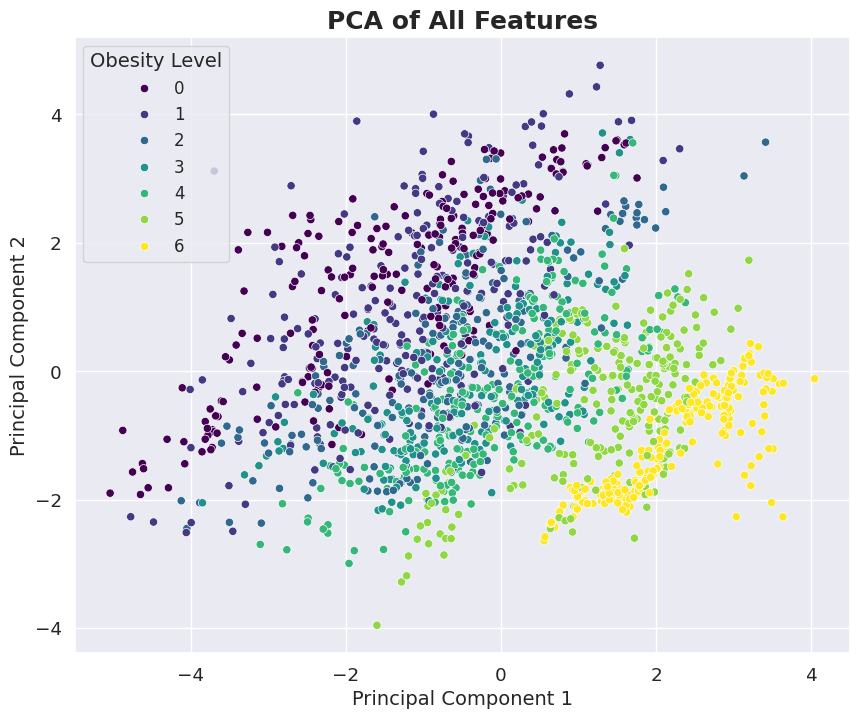

In [ ]:
# The features are already scaled
pca_c2 = PCA(n_components=2)
principal_components_c2 = pca_c2.fit_transform(final_train_scaled)
pca_df_for_2 = pd.DataFrame(data=principal_components_c2, columns=['PC1', 'PC2'])
pca_df_for_2['NObesity_encoded'] = y_train.values  # Attach the target variable for color coding

# Visualizing the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df_for_2, x='PC1', y='PC2', hue='NObesity_encoded', palette='viridis')
plt.title("PCA of All Features", fontsize=18, fontweight='bold')
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.legend(title="Obesity Level", fontsize=12, title_fontsize=14)
plt.show()

In [ ]:
# Print the explained variance ratio # with 2 pcas i got the ratio of 37% [0.21647315 0.16274018]
#If the ratio is low (e.g., less than 80%), it suggests that significant information might be lost by selecting only pca compenant
print("Explained Variance Ratio:", pca_c2.explained_variance_ratio_)
# print("Cumulative Explained Variance Ratio:", np.cumsum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.21647315 0.16274018]


## Visualizing with 3 comp

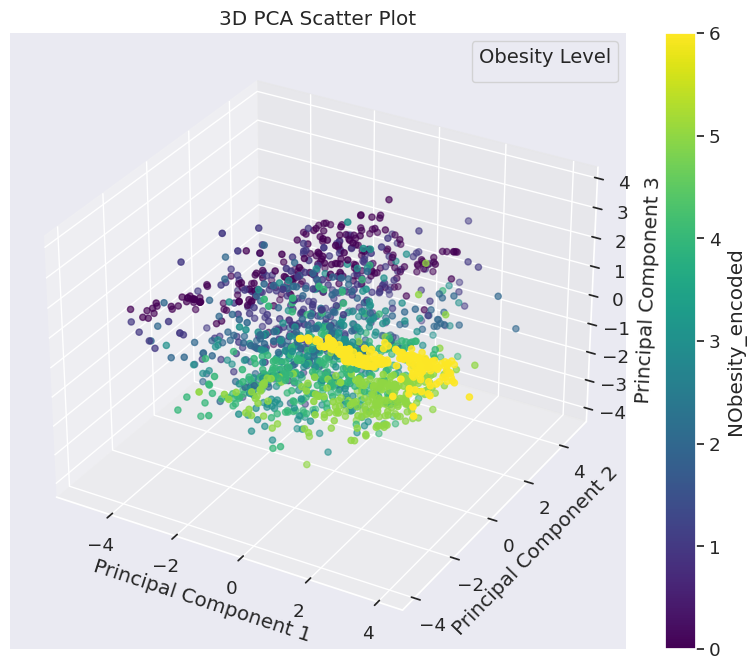

In [ ]:
pca_3d = PCA(n_components=3)
principal_components_for3d = pca_3d.fit_transform(final_train_scaled)
pca_df_3d = pd.DataFrame(data=principal_components_for3d, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter= ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c=y_train.values, cmap='viridis')
ax.set_title("PCA of Numerical Features", fontsize=18, fontweight='bold')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatter Plot')
fig.colorbar(scatter, label='NObesity_encoded')
plt.legend(title="Obesity Level", fontsize=12, title_fontsize=14)
plt.show()

In [ ]:
# Print the explained variance ratio # with 2 pcas i got the ratio of 31% [0.14462581 0.09182647 0.08108646]
#If the ratio is low (e.g., less than 80%), it suggests that significant information might be lost by selecting only 3 pca compenant
print("Explained Variance Ratio:", pca_3d.explained_variance_ratio_)

Explained Variance Ratio: [0.21647315 0.16274018 0.12994386]


## Final PCA

In [ ]:
# Full PCA letting PCA selecting the number of components
# X_train_scaled = scaler.fit_transform(final_train)
# X_test_scaled = scaler.transform(final_test)

X_train_scaled = final_train_scaled.copy()
X_test_scaled = final_test_scaled.copy()

pca = PCA()

x_train_pca = pca.fit_transform(X_train_scaled)
x_test_pca = pca.transform(X_test_scaled)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
'''The first few components (the first 10-15) have relatively larger explained variance ratios
 very small exponents (e.g., 1e-17), contribute very little to explaining the variance. '''

[2.16473151e-01 1.62740185e-01 1.29943863e-01 1.16833877e-01
 8.61991463e-02 6.29148468e-02 5.72008927e-02 4.78810117e-02
 2.87119287e-02 1.69138634e-02 1.53486075e-02 1.33497026e-02
 1.28859920e-02 1.05711011e-02 6.24930696e-03 3.47265666e-03
 3.07157166e-03 2.78407397e-03 2.73613223e-03 1.72436491e-03
 1.00192966e-03 5.22798346e-04 2.61566125e-04 2.07431003e-04
 5.27832508e-17 2.90423923e-17 2.30217925e-17 1.25655789e-17
 4.68488970e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
1.0


'The first few components (the first 10-15) have relatively larger explained variance ratios\n very small exponents (e.g., 1e-17), contribute very little to explaining the variance. '

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components:", n_components)
# minimum number of principal components needed to capture at least 95% of the variance in the data.

Optimal number of components: 12


In [ ]:
# We will only choose 12 components which was selected ealier
pca_df_train = pd.DataFrame(data=x_train_pca[:, :n_components], columns=[f'PC{i+1}' for i in range(n_components)])
pca_df_test = pd.DataFrame(data=x_test_pca[:, :n_components], columns=[f'PC{i+1}' for i in range(n_components)])

print(pca_df_train.shape)
print(pca_df_test.shape)

(1688, 12)
(423, 12)


In [ ]:
pca_df_train.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.658518 -1.186845 -0.551976  1.775842  0.590822  0.937943 -1.223813   
1 -1.207718 -0.276064 -0.013617 -0.794149  1.832065 -0.885846 -1.278777   
2 -1.534785 -1.215606  2.015969 -0.325402  0.391585 -0.691658  0.179216   
3  1.380324 -2.000127  1.310268 -0.752001 -0.599365  0.758667 -0.283291   
4 -0.705339  1.313321  1.289259  1.037062  0.411047 -0.176266 -0.173672   

        PC8       PC9      PC10      PC11      PC12  
0  0.484681  0.015625 -0.037737 -0.092460 -0.030231  
1  0.415242  0.445986  0.619693  0.156398 -0.531041  
2 -0.555089 -1.122738  0.332616  0.207448  0.807836  
3 -0.412775  0.038568  0.058100  0.162160 -0.214152  
4  1.260895  0.307078 -0.574954  0.715985 -0.406823

In [ ]:
# to_show = 3
# # Correct way to use pd.concat: Provide objects as a list
# df_pplot = pd.concat([pca_df_train.copy(), target], axis=1)
# #Since you have 10 PCs, it generates a 10x10 grid to show the relationships between all possible pairs of PCs.
# df_pplot.head()

# # # Pass the pandas Series to the 'hue' argument
# sns.pairplot(df_pplot, hue='NObeyesdad', vars=[f'PC{i+1}' for i in range(to_show)])
# plt.show()

Partial Clustering by Obesity Level:

Notice how certain colors appear more concentrated in some regions. For instance, if you see more of the purple dots (level 0) toward the left side, that suggests PC1 (and possibly PC2) may be capturing variance related to lower weight.
Conversely, if the yellow or green dots (higher obesity levels) cluster more to the right or top, it indicates that those components capture variance correlated with higher weight or related features.

The numbers printed by pca.explained_variance_ratio_ tell you how much of the total variance in the original dataset is captured by each principal component.
For example, if PC1 explains ~20% of the variance and PC2 explains ~15%, then together they represent ~35% of the variance in the original data.
This means that there is still a significant amount of variance (65% in this example) not captured by these two components.

In [ ]:
xgb_clf = XGBClassifier(booster='gbtree',
                    tree_method="hist",
                    objective='multi:softmax',
                    num_class=len(set(y_train)),
                    n_estimators=300,
                    max_depth=6,
                    verbosity=0)

In [ ]:
xgb_clf.fit(pca_df_train, y_train)
y_pred = xgb_clf.predict(pca_df_test)
print(classification_report(y_test, y_pred, target_names=sorted_labels))
accuracies['XGBoost(test) after PCA'] = accuracy_score(y_test, y_pred)

                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.93      0.90        54
      Normal_Weight       0.76      0.70      0.73        53
 Overweight_Level_I       0.82      0.83      0.83        66
Overweight_Level_II       0.82      0.88      0.85        52
     Obesity_Type_I       0.96      0.87      0.92        94
    Obesity_Type_II       0.91      1.00      0.95        51
   Obesity_Type_III       1.00      1.00      1.00        53

           accuracy                           0.88       423
          macro avg       0.88      0.89      0.88       423
       weighted avg       0.89      0.88      0.88       423



In [ ]:
svm_clf = SVC(C=20, gamma='auto', kernel='rbf')

svm_clf.fit(pca_df_train, y_train)
y_pred = svm_clf.predict(pca_df_test)
scorer = make_scorer(accuracy_score)
print(f'accuracy: {accuracy_score(y_test, y_pred):0.3f}')

print(classification_report(y_test, y_pred, target_names=sorted_labels))
accuracies['SVM(test) after PCA'] = accuracy_score(y_test, y_pred)

accuracy: 0.962
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.94      0.96        54
      Normal_Weight       0.90      0.87      0.88        53
 Overweight_Level_I       0.91      0.95      0.93        66
Overweight_Level_II       0.93      1.00      0.96        52
     Obesity_Type_I       1.00      0.97      0.98        94
    Obesity_Type_II       1.00      1.00      1.00        51
   Obesity_Type_III       1.00      1.00      1.00        53

           accuracy                           0.96       423
          macro avg       0.96      0.96      0.96       423
       weighted avg       0.96      0.96      0.96       423



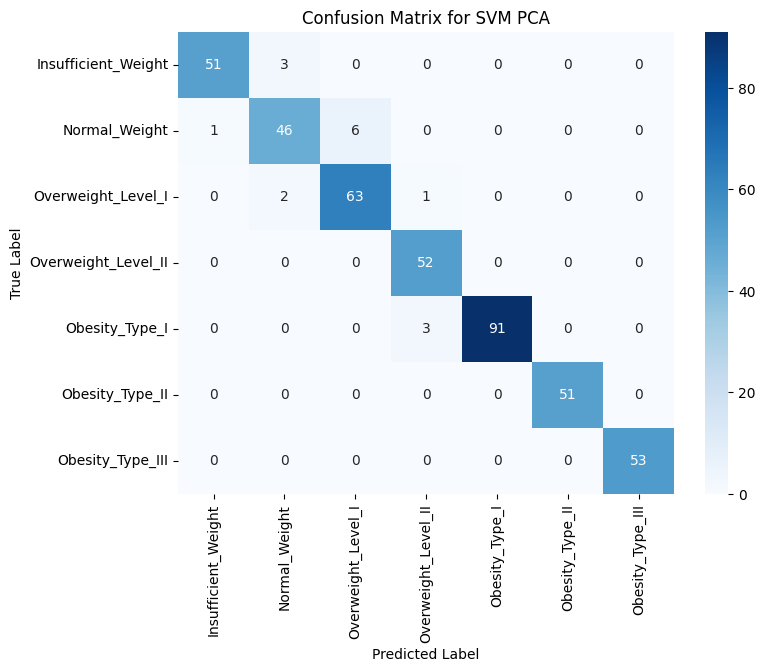

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM PCA')
plt.show()

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters as needed
rf_clf.fit(pca_df_train, y_train)
y_pred_rf = rf_clf.predict(pca_df_test)

print(classification_report(y_test, y_pred_rf, target_names=sorted_labels))
accuracies['Random Forest(test) after PCA'] = accuracy_score(y_test, y_pred_rf)

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93        54
      Normal_Weight       0.76      0.72      0.74        53
 Overweight_Level_I       0.84      0.80      0.82        66
Overweight_Level_II       0.80      0.92      0.86        52
     Obesity_Type_I       0.93      0.89      0.91        94
    Obesity_Type_II       0.94      1.00      0.97        51
   Obesity_Type_III       1.00      1.00      1.00        53

           accuracy                           0.89       423
          macro avg       0.89      0.89      0.89       423
       weighted avg       0.89      0.89      0.89       423



In [ ]:
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
accuracy_df

Model  Accuracy
0                 XGBoost with CrossValidation  0.978723
1                                      XGBoost  0.985816
2         XGBoost with GridSearch on test data  0.985816
3                                  SVM on test  0.962175
4                          SVM with GridSearch  0.960910
5             SVM with GridSearch on test data  0.969267
6                         Custom Random Forest  0.971631
7                    Random Forest on test set  0.983452
8   Random Forest with GridSearch on test data  0.981087
9                      XGBoost(test) after PCA  0.884161
10                         SVM(test) after PCA  0.940898
11               Random Forest(test) after PCA  0.891253

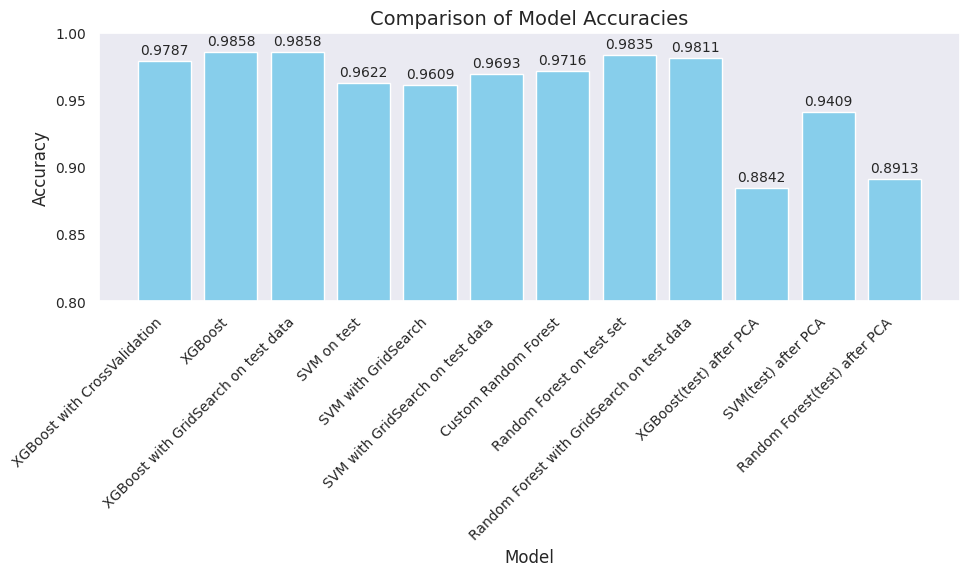

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0.8, 1.0)
plt.tight_layout()

for i, v in enumerate(accuracy_df['Accuracy']):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10)

plt.grid(False)
plt.show()

In [ ]:
# important features selected by the models
importance_df_rf.head(5)

Feature  Importance
0          BMI    0.321560
1       Weight    0.182803
2         FCVC    0.052082
3  Meal_Habits    0.050686
4       Height    0.046085

In [ ]:
importance_df_xgb.head(5)

Feature  Importance
1              BMI    0.442742
14   Gender_Female    0.298041
11         FAVC_no    0.040953
22     Meal_Habits    0.036754
7   CALC_Sometimes    0.026842

In [ ]:
# top features by every classes
top_features_df

Insufficient_Weight  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                                  Age   
Rank 4    family_history_with_overweight_no   
Rank 5                       CAEC_Sometimes   
Rank 6                      CAEC_Frequently   
Rank 7   family_history_with_overweight_yes   
Rank 8                                  NCP   
Rank 9                          Meal_Habits   
Rank 10                              Height   

                              Normal_Weight  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                       CAEC_Sometimes   
Rank 4    family_history_with_overweight_no   
Rank 5   family_history_with_overweight_yes   
Rank 6                                 FCVC   
Rank 7                                  Age   
Rank 8                          Meal_Habits   
Rank 9                                  TUE   
Rank 10                                 NCP   

                         Overweight_Level_I  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                                  Age   
Rank 4                       CALC_Sometimes   
Rank 5                              CALC_no   
Rank 6                          Meal_Habits   
Rank 7                                 FCVC   
Rank 8                               Height   
Rank 9    family_history_with_overweight_no   
Rank 10  family_history_with_overweight_yes   

                       Overweight_Level_II  \
Rank 1                                 BMI   
Rank 2                              Weight   
Rank 3                                 Age   
Rank 4                              Height   
Rank 5   family_history_with_overweight_no   
Rank 6                      CALC_Sometimes   
Rank 7                         Gender_Male   
Rank 8                                FCVC   
Rank 9                         Meal_Habits   
Rank 10                            FAVC_no   

                             Obesity_Type_I  \
Rank 1                                  BMI   
Rank 2                               Weight   
Rank 3                          Meal_Habits   
Rank 4                                 FCVC   
Rank 5                               Height   
Rank 6    family_history_with_overweight_no   
Rank 7   family_history_with_overweight_yes   
Rank 8                                  Age   
Rank 9                       CAEC_Sometimes   
Rank 10                         Gender_Male   

                            Obesity_Type_II                   Obesity_Type_III  
Rank 1                                  BMI                                BMI  
Rank 2                               Weight                             Weight  
Rank 3                          Gender_Male                        Gender_Male  
Rank 4                        Gender_Female                               FCVC  
Rank 5                                  Age                        Meal_Habits  
Rank 6                                 FCVC                      Gender_Female  
Rank 7                          Meal_Habits                     CALC_Sometimes  
Rank 8                               Height                                TUE  
Rank 9                                 CH2O                            CALC_no  
Rank 10  family_history_with_overweight_yes  family_history_with_overweight_no